<h1>
<center>Navid Bahadoran</center>
</h1>
<h1>
<center>Homework 7, due October 27th, 11:59pm</center>
</h1>

<h2>
<center>October 19, 2023</center>
</h2>
1. Download the image horse025b.png from Canvas, containing an image of a
horse shape of size $84 \times 128$ pixels.
The goal of this project is to train a regression Neural Network to predict the value
of a pixel $I(x, y)$ given its coordinates $(x, y)$. We will use the square loss functions on
the training examples $(x_{i}, y_{i}, I(x_{i}, y_{i})), i = 1, ..., n:$
$$S(w) =\frac{1}{n}\sum_{i=1}^{n}(I(x_{i}, y_{i}) − fw(x_{i}, y_{i}))^2 \quad(1)$$
where $(x_{i}, y_{i}) \in \{1, ..., 84\} \times \{1, ..., 128\}$ are all $n = 128 · 84 = 10752$ pixels of the
image.<br> 
All $NNs \ f_{w}(x, y)$ we will train have a $2D$ input $(x, y)$ and a $1D$ output, but we will
experiment with different numbers of hidden layers.<br>
Try to use a $GPU$ and $CUDA$ for faster training. If you want, for better convergence,
you could try to standardize the inputs $(x_{i}, y_{i})$ to have zero means and std 1, and the
outputs to have zero mean.

In [56]:
from PIL import Image
import torch
import torchvision
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
# from IPython.display import display, Markdown

# Determine the device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"The calculation was done using {device}")
EPOCHS = 300
BATCHSIZE = 64
LEARN_RATE = 0.03

class NeuralNetwork(torch.nn.Module):
    def __init__(self, hidden_layers: torch.nn.Sequential):
        super().__init__()
        self.hidden_layers = hidden_layers

    def forward(self, x):
        x = self.hidden_layers(x)
        return x

def preprocess_data(horse025b_path):
    # Data Preprocessing - Horse Image
    horse_image = Image.open(horse025b_path).convert("L")
    to_tensor = torchvision.transforms.ToTensor()
    horse_tensor = to_tensor(horse_image)
    flat_horse = horse_tensor.flatten()
    horse_scaler = StandardScaler(with_std=False)
    std_flat_horse = horse_scaler.fit_transform(flat_horse.reshape(-1, 1))
    std_flat_horse = torch.tensor(std_flat_horse).squeeze().float().to(device)
    assert not std_flat_horse.isnan().any()

    # Data Preprocessing - Coordinates
    height, width = horse_tensor.squeeze().shape
    coordinates = torch.tensor([(x, y) for x in range(height) for y in range(width)])
    coordinate_scaler = StandardScaler()
    std_coordinates = coordinate_scaler.fit_transform(coordinates)
    std_coordinates = torch.tensor(std_coordinates).float().to(device)
    assert not std_coordinates.isnan().any()

    return std_coordinates, std_flat_horse, height, width, horse_scaler

def train_neural_network(coordinates, flat_horse, height, width, hidden_layers, horse_scaler=None,isdisplay=True):
    # Create a DataLoader to load data in batches
    dataset = torch.utils.data.TensorDataset(coordinates, flat_horse)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCHSIZE, shuffle=True)

    # Define Training Specifics
    neural_net = NeuralNetwork(hidden_layers).to(device)
    optimizer = torch.optim.SGD(neural_net.parameters(), lr=LEARN_RATE)
    loss_fn = torch.nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
    losses = []

    # Training loop
    for epoch in range(EPOCHS):
        if isdisplay:
            print(f"----- Epoch {epoch+1} -----")
        losses.append(train_loop(neural_net, data_loader, optimizer, loss_fn, isdisplay))
        scheduler.step()
    if isdisplay:
        print('Training Done')

    # Move to evaluation mode
    neural_net.eval()

    # Reconstruct Image
    with torch.no_grad():
        std_intensities = neural_net(coordinates).cpu()
#         target = flat_horse.view(-1, 1).expand(-1, 128)   # Reshape the target tensor
#         loss = loss_fn(std_intensities, target)
        intensities = np.clip(horse_scaler.inverse_transform(std_intensities), 0., 1.)
        intensities = (intensities * 255).astype(np.uint8)
        reconstructed_horse = Image.fromarray(intensities.reshape(height, width))

    return losses, reconstructed_horse

def train_loop(neural_net, data_loader, optimizer, loss_fn, isdisplay=True):
    """ One epoch in the training
    """
    data_size = len(data_loader.dataset)
    neural_net.train()  # Not needed, but for best practice
    for batch, (X, y) in enumerate(data_loader):
        # Compute prediction and loss (Forward pass)
        if torch.isnan(X).any():
            raise ValueError("NaN values found in inputs!")
        pred = neural_net(X).squeeze()
#         y = y.view(-1,1)
        if torch.isnan(pred).any():
            raise ValueError("NaN values found in predictions!")
        loss = loss_fn(pred, y)
        if torch.isnan(loss).any():
            raise ValueError("NaN values found in loss!")

        # Backpropagation
        loss.backward()
        optimizer.step()
        # Ensure we don't accumulate the gradient
        optimizer.zero_grad()

        if batch % 50 == 0 and isdisplay:
            lossvalue, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {lossvalue:>2f} [{current}][{data_size}]")
    return loss.item()

# Paths and configuration
horse025b_path = r'D:\Pycharm\Courses\STA5635\HW7\horse025b.png'  # Replace with your image path



# Main program
def Hw_7(hidden_layers, isdisplay):
    coordinates, flat_horse, height, width, horse_scaler  = preprocess_data(horse025b_path)
    losses, reconstructed_horse = train_neural_network(coordinates,flat_horse, height, width, hidden_layers,horse_scaler,isdisplay)

    # Show plots and images
#     display(Markdown('The following plot shows the epochs vs the training loss.'))
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, EPOCHS + 1), losses,  label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Epochs vs Training Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

#     display(Markdown('The following is the reconstructed image.'))
    display(reconstructed_horse)

The calculation was done using cpu


**a) Train a $NN$ with one hidden layer containing 128 neurons, followed by $ReLU$.
Train the NN for 300 epochs using the square loss (1). Use the $SGD$ optimizer
with minibatch size 64, and an appropriate learning rate (e.g. 0.003). Reduce the
learning rate to half every 100 epochs. Show a plot of the loss function vs epoch
number. Display the image reconstructed from the trained $NN f_{w}(i, j), i \in
{1, ..., 84}, j \in {1, ..., 128}. (2 points)$**

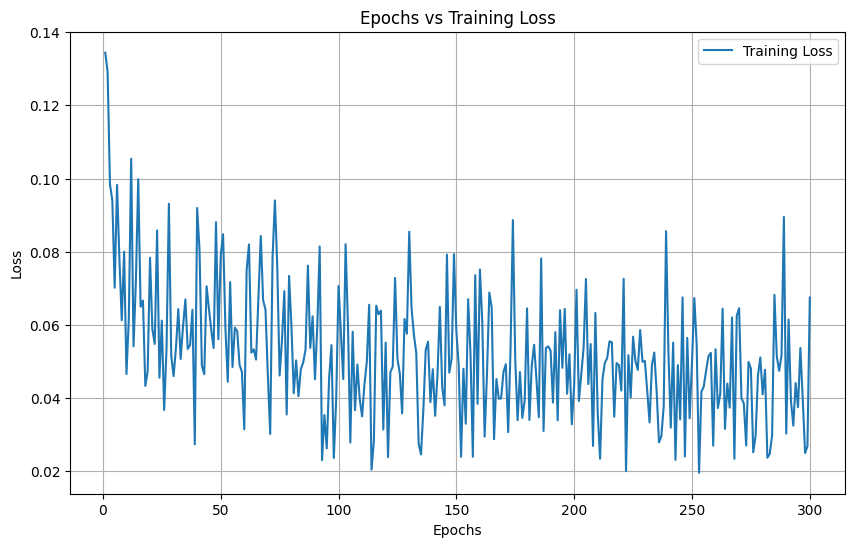

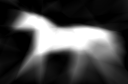

In [60]:
hidden_layers = torch.nn.Sequential(
    torch.nn.Linear(2, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 1)
)
Hw_7(hidden_layers, False)

**b)Repeat point a) with a $NN$ with two hidden layers, first one with 32 neurons and
second one with 128 neurons, each followed by $ReLU$. (2 points)**

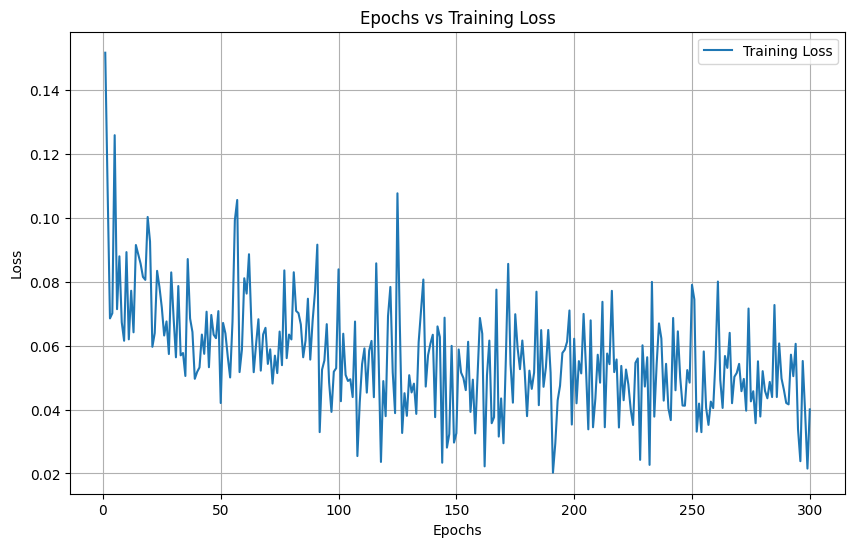

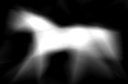

In [59]:
hidden_layers = torch.nn.Sequential(
    torch.nn.Linear(2,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,128),
    torch.nn.ReLU(),
    torch.nn.Linear(128,1)
)

Hw_7(hidden_layers, False)

**c)Repeat point a) with a $NN$ with three hidden layers, with 32, 64 and 128 neurons
respectively, each followed by $ReLU$. (2 points)**

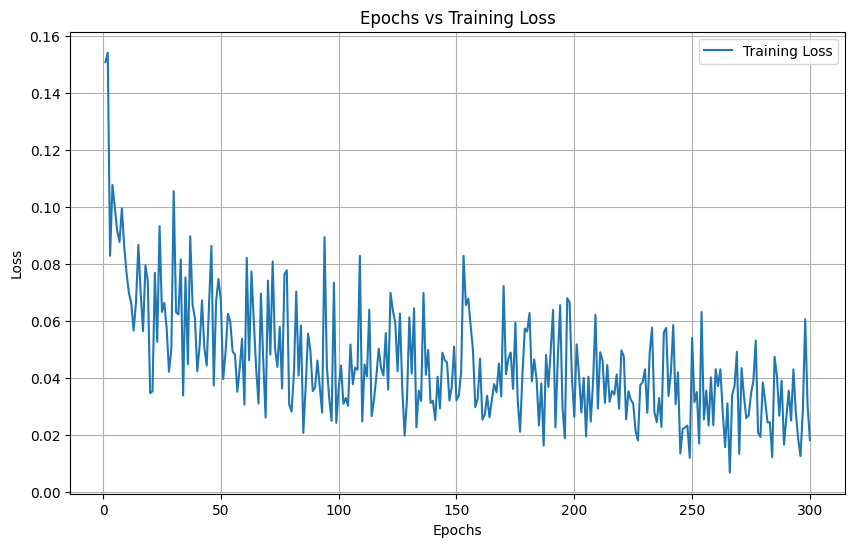

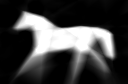

In [58]:
hidden_layers = torch.nn.Sequential(
    torch.nn.Linear(2,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,64),
    torch.nn.ReLU(),
    torch.nn.Linear(64,128),
    torch.nn.ReLU(),
    torch.nn.Linear(128,1)
)
Hw_7(hidden_layers, False)

**d)Repeat point a) with a $NN$ with four hidden layers, with 32, 64, 128 and 128
neurons respectively, each followed by $ReLU$. (3 points)**

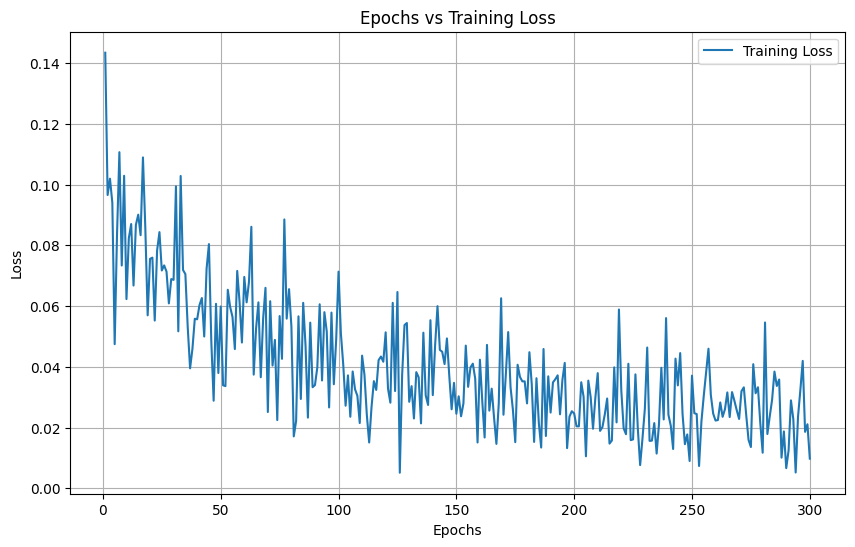

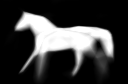

In [57]:
hidden_layers = torch.nn.Sequential(
    torch.nn.Linear(2,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,64),
    torch.nn.ReLU(),
    torch.nn.Linear(64,128),
    torch.nn.ReLU(),
    torch.nn.Linear(128,128),
    torch.nn.ReLU(),
    torch.nn.Linear(128,1)
)

Hw_7(hidden_layers, isdisplay=False)